Este agarra los datos del csv con la matriz de grayscale de cada espectrograma, y se los pasa al modelo de CNN de PyTorch (definido en aux file models.py), los guarda para poder llamarlo sin re-entrenar desde otros archivos

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import cupy as cp
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [45]:
# UNCOMMENT THE ONE BEING USED

# NOT NOISE-REDUCED
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

# NOISE-REDUCED
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data2.csv'))

In [47]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0
features = features.reshape(-1, 1, 313, 224)

In [48]:
print("features shape:", features.shape)
print("labels shape:", labels.shape)

features shape: (3070, 1, 313, 224)
labels shape: (3070,)


In [49]:
# 1. Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# 2. Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

# 3. Create datasets and dataloaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [50]:
import importlib
importlib.reload(models)

<module 'utils.models' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ChirpID-backend\\utils\\models.py'>

Reset the Model

In [51]:
def reset_model(lr=0.001, num_classes=28):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.BirdCNN(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion, device

# Usage:
model, optimizer, criterion, device = reset_model()

Run to Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.BirdCNN(num_classes=28).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 250
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
for epoch in pbar:
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
    pbar.set_postfix(train_acc=f"{train_acc:.3f}", train_loss=f"{train_loss:.4f}")

Epoch 175/175: 100%|██████████| 175/175 [11:20<00:00,  3.89s/epoch, train_acc=0.859, train_loss=0.4242]


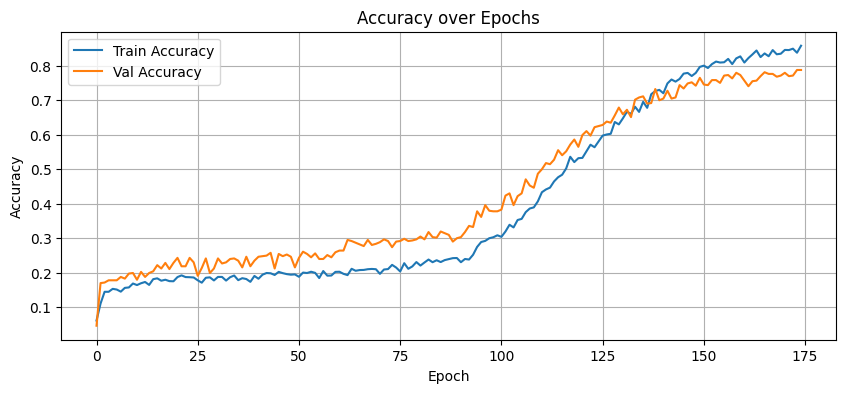

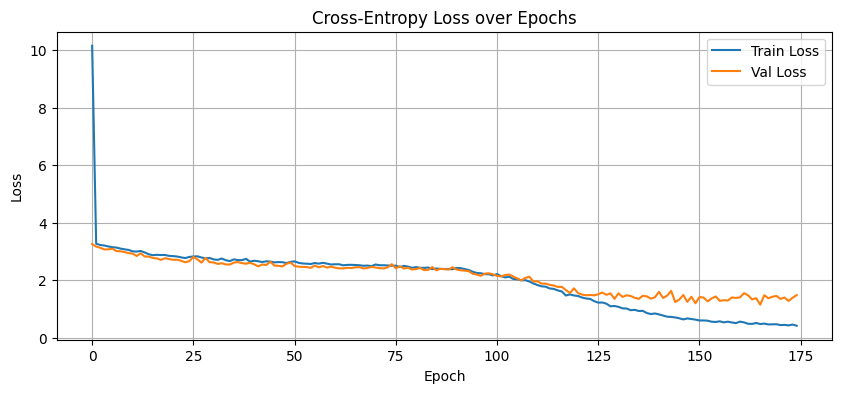

Lowest Train Loss: 0.4242
Lowest Val Loss:   1.1555
Highest Train Accuracy: 85.87%
Highest Val Accuracy:   78.83%


In [42]:
# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cross-Entropy Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Summary
print(f"Lowest Train Loss: {min(train_losses):.4f}")
print(f"Lowest Val Loss:   {min(val_losses):.4f}")
print(f"Highest Train Accuracy: {max(train_accuracies)*100:.2f}%")
print(f"Highest Val Accuracy:   {max(val_accuracies)*100:.2f}%")
